<a href="https://colab.research.google.com/github/ChoiSenn/Study/blob/main/AI/PyTorch/%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%EB%B9%84%EA%B5%90(IMDB_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.4 신경망 이진분류

<br>

In [ ]:
import keras
keras.__version__  # 버전 체크

'2.9.0'

## IMDB 데이터셋

IMDB
- 인터넷 영화 데이터베이스로부터 가져온 (호불호)양극단의 리뷰 50,000개로 이루어진 데이터셋.
- 훈련 데이터 25,000개와 테스트 데이터 25,000개로 구성.
- 각각 50%는 부정, 50%는 긍정적인 리뷰로 구성.
- 케라스에 포함.
- 전처리 되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있음.

<br>

훈련 데이터와 테스트 데이터를 나누는 이유 : 같은 데이터에서 모델을 훈련하고 테스트를 동시에 하는 것이 아니라, 새로운 데이터에 대해 모델의 성능을 검증하기 위해.

<br>

먼저 IMDB 데이터셋을 로드.

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

train_data[0]  # train data의 리뷰 출력
train_labels[0]  # train data의 긍정/부정 출력
max([max(sequence) for sequence in train_data])  # 단어 인덱스가 가장 많은 쪽 출력

9999

매개변수로 준 num_words=10000은 훈련 데이터에서 가장 자주 나타나는 단어 10,000개만 사용하겠다는 의미. 그리고 드물게 나타나는 단어를 무시하여 적절한 크기의 벡터 데이터 얻음.

*train_data[0]으로 0번째 리뷰 출력(숫자 시퀀스 형태), train_labels[0]으로 0번째 리뷰의 부정/긍정을 출력(부정은 0, 긍정은 1)*

*자주 등장하는 단어 10,000개로 제한했기에 인덱스는 10,000을 넘지 않음.*

<br>

train_data와 word_index(단어와 정수를 매핑한 딕셔너리)를 이용해 리뷰 데이터를 원래 영어 단어로 변환해볼 수 있음.

In [ ]:
word_index = imdb.get_word_index()  # 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # 정수 인덱스와 단어를 매핑하도록 뒤집음

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])  # 디코딩. 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺌.

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

*숫자 시퀀스 변환 전의 원래 리뷰가 출력된 모습*

<br>

## 데이터 준비

숫자 리스트로 바로 주입할 수 없으므로 다음과 같은 두 가지 방식으로 리스트를 텐서로 변환.
- 같은 길이가 되도록 리스트에 padding을 추가하고 (samples, sequesnce_length) 크기의 정수 텐서로 변환. 정수 텐서를 다룰 수 있는 층을 신경망의 첫 층으로 사용.(Embedding 층)
- 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환. 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망 첫 번째 층으로 사용.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듦
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듦
    return results

x_train = vectorize_sequences(train_data)  # 훈련 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data) 

y_train = np.asarray(train_labels).astype('float32')  # 레이블을 벡터로 변환
y_test = np.asarray(test_labels).astype('float32')

x_train[0]  # 확인

array([0., 1., 1., ..., 0., 0., 0.])

*원-핫 인코딩을 이용하여 벡터로 변환한 모습*

<br>

## 신경망 모델 만들기

입력 데이터가 벡터이고 레이블은 스칼라(1 or 0)인 경우에 잘 작동하는 네트워크는 relu 활성화 함수를 사용한 완전연결층을 그냥 쌓은 네트워크.

Dense 층에 전달할 매개변수는 은닉 유닛의 개수. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 됨.

16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻. 입력 데이터와 W를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영. 해당 차원을 '신경망이 내제된 표현을 학습할 때 가질 수 있는 자유도'로 이해 가능.

은닉 유닛을 늘려 더 고차원으로 만들면 신경망이 더 복잡한 표현을 학습할 수 있지만, 계산 비용이 커지고 원치 않은 패턴을 학습할 수 있음.

우선은 16개의 은닉 유닛을 가진 두 개의 은닉층과 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층을 두기로 함.

중간의 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률을 출력하기 위해 시그모이드 활성화 함수를 사용. relu는 음수를 0으로 만드는 함수. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석 가능.

<br>

신경망을 케라스로 구현.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

손실 함수와 옵티마이저를 선택.

이진 분류 문제이고 신경망의 출력이 확률이기 때문에 binary_crossentropy 손실이 적합. (확률을 출력하는 모델을 사용 시에는 크로스엔트로피가 최선의 선택)

다음으로 rmsprop 옵티마이저와 binary_crossentropy 손실 함수로 모델을 설정. 훈련하는 동안 accuracy로 모니터링.

In [ ]:
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

<br>

## 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 일정 샘플을 떼어내서 검증 세트를 만들어야 함.

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개씩 미니 배치를 만들어 20번 epochs 동안 훈련시킴. 동시에 따로 떼어놓은 10,000개의 샘플에 있어서 loss와 accuracy를 측정.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

Epoch 1/20
30/30 [==============================] - 4s 44ms/step - loss: 0.5121 - accuracy: 0.7809 - val_loss: 0.3855 - val_accuracy: 0.8632
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.3016 - accuracy: 0.9044 - val_loss: 0.3247 - val_accuracy: 0.8735
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2234 - accuracy: 0.9265 - val_loss: 0.2798 - val_accuracy: 0.8890
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1728 - accuracy: 0.9453 - val_loss: 0.2952 - val_accuracy: 0.8808
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1433 - accuracy: 0.9539 - val_loss: 0.2832 - val_accuracy: 0.8871
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1193 - accuracy: 0.9631 - val_loss: 0.3005 - val_accuracy: 0.8808
Epoch 7/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1000 - accuracy: 0.9690 - val_loss: 0.3110 - val_accuracy: 0.8813
Epoch 8/20
30

*한 에폭이 끝날 때마다 loss와 accuracy를 계산하여 출력된 모습.*

<br>

model.fit() 메소드는 History 객체를 반환. 이는 훈련하는 동안 발생한 모든 정보를 담은 딕셔너리인 history 속성을 갖고 있음.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

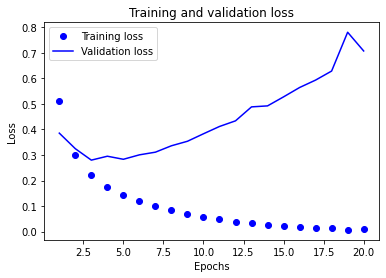

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

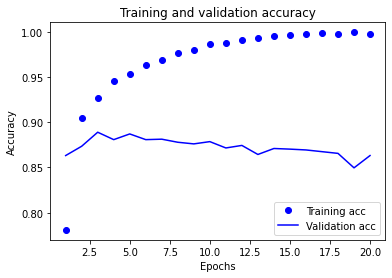

In [ ]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

*네 가지 측정 지표를 이용해 훈련과 검증 데이터에 대한 손실과 정확도를 그려본 모습. 점선은 훈련 손실과 정확도이며, 실선은 검증 손실과 정확도.*

<br>

볼 수 있듯, 훈련 손실이 에폭마다 감소하고 훈련 정확도는 에폭마다 증가. 경사 하강법에 따라 반복마다 최소화됨. 그러나 검증 손실과 정확도는 감소/증가하다가 어느 순간에서 역전되는 모습을 확인 가능. 어느 순간에 과적합되어 훈련 세트 이외의 데이터에는 일반화 되지 못한다는 것을 알 수 있음.

이런 경우, 과대적합 방지를 위해 특정 에폭 이후에 훈련을 중지할 수 있음.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.4675 - accuracy: 0.8208
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2653 - accuracy: 0.9076
Epoch 3/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2062 - accuracy: 0.9259
Epoch 4/4
782/782 [==============================] - 3s 3ms/step - loss: 0.2876 - accuracy: 0.8864


[0.2875913083553314, 0.8863599896430969]

*87%의 정확도를 달성한 모습*

<br>

## 훈련된 모델로 새로운 데이터에 대해 예측하기

predict 메서드를 사용해서 리뷰가 긍정적일 확률 예측 가능.

In [ ]:
model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


array([[0.17640845],
       [0.99958915],
       [0.8290335 ],
       ...,
       [0.1219105 ],
       [0.07365954],
       [0.5360473 ]], dtype=float32)

*모델이 어떤 샘플에 대해서는 0.9, 0.1 정도로 확신을 가지고 있지만, 어떤 샘플에 대해서는 0.7 정도로 애매한 결과를 보임*

<br>

## 추가 실험

1. (한 개 또는) 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인.

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))  # 은닉층 하나 추가
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 44ms/step - loss: 0.1471 - accuracy: 0.9456 - val_loss: 0.1453 - val_accuracy: 0.9510
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1131 - accuracy: 0.9625 - val_loss: 0.1582 - val_accuracy: 0.9427
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0926 - accuracy: 0.9713 - val_loss: 0.1809 - val_accuracy: 0.9321
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0805 - accuracy: 0.9757 - val_loss: 0.2118 - val_accuracy: 0.9215
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0636 - accuracy: 0.9832 - val_loss: 0.2101 - val_accuracy: 0.9248
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0548 - accuracy: 0.9849 - val_loss: 0.2484 - val_accuracy: 0.9144
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0435 - accuracy: 0.9899 - val_loss: 0.2569 - val_accuracy: 0.9130
Epoch 8/20
30

*86%의 정확도로, 두 개의 은닉층을 사용하였을 때보다는 약간 정확도가 하락한 모습.*

<br>

2. 층의 은닉 유닛을 추가하거나 줄이기 (32개)

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 49ms/step - loss: 0.1518 - accuracy: 0.9446 - val_loss: 0.1475 - val_accuracy: 0.9490
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1179 - accuracy: 0.9616 - val_loss: 0.1649 - val_accuracy: 0.9397
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0982 - accuracy: 0.9704 - val_loss: 0.1773 - val_accuracy: 0.9355
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0820 - accuracy: 0.9756 - val_loss: 0.2093 - val_accuracy: 0.9207
Epoch 5/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0666 - accuracy: 0.9813 - val_loss: 0.2170 - val_accuracy: 0.9209
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0550 - accuracy: 0.9859 - val_loss: 0.2578 - val_accuracy: 0.9084
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0461 - accuracy: 0.9882 - val_loss: 0.2536 - val_accuracy: 0.9157
Epoch 8/20
30

[0.3938412070274353, 0.8511999845504761]

*88% 정도의 비슷한 정확도를 보임.*

<br>

3. binary_crossentropy 대신에 mse 손실 함수 사용

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 54ms/step - loss: 0.1403 - accuracy: 0.9507 - val_loss: 0.1366 - val_accuracy: 0.9515
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1103 - accuracy: 0.9625 - val_loss: 0.1496 - val_accuracy: 0.9447
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0821 - accuracy: 0.9747 - val_loss: 0.2285 - val_accuracy: 0.9147
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0723 - accuracy: 0.9774 - val_loss: 0.2226 - val_accuracy: 0.9193
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0530 - accuracy: 0.9863 - val_loss: 0.2129 - val_accuracy: 0.9243
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0424 - accuracy: 0.9889 - val_loss: 0.2407 - val_accuracy: 0.9189
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0350 - accuracy: 0.9902 - val_loss: 0.2721 - val_accuracy: 0.9144
Epoch 8/20
30

*역시나 88% 정도의 정확도*

4. relu 대신 tanh 활성화 함수 사용

In [ ]:
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',  # 케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실함수, 측정지표를 문자열로 지정하는 것이 가능.
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))  # validation_data 매개변수에 검증 데이터 전달

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)  # 에폭 수를 줄임.
results = model.evaluate(x_test, y_test)

results

Epoch 1/20
30/30 [==============================] - 2s 49ms/step - loss: 0.5290 - accuracy: 0.7761 - val_loss: 0.4048 - val_accuracy: 0.8529
Epoch 2/20
30/30 [==============================] - 1s 39ms/step - loss: 0.3113 - accuracy: 0.9005 - val_loss: 0.3050 - val_accuracy: 0.8894
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2253 - accuracy: 0.9264 - val_loss: 0.2797 - val_accuracy: 0.8885
Epoch 4/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1785 - accuracy: 0.9408 - val_loss: 0.2838 - val_accuracy: 0.8863
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1437 - accuracy: 0.9550 - val_loss: 0.2865 - val_accuracy: 0.8851
Epoch 6/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1178 - accuracy: 0.9645 - val_loss: 0.3112 - val_accuracy: 0.8804
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0955 - accuracy: 0.9720 - val_loss: 0.3211 - val_accuracy: 0.8825
Epoch 8/20
30

[0.3205924332141876, 0.8799600005149841]

*88% 정도의 정확도*

#6.2 순환신경망 (RNN)

## 케라스의 순환 층


SimpleRNN
- 케라스에서 제공하는 기초적인 RNN 구조.
- 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리. 즉, (timesteps, input_features) 크기가 아니라 (batch_size, timesteps, input_features) 크기의 입력을 받음.
- 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나, 입력 시퀀스에 대한 마지막 출력만 반환할 수 있음. (return_sequences 매개변수로 선택)

In [ ]:
import keras
keras.__version__

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


*네트워크의 표현력 증가를 위해 여러 개의 순환 층을 차례대로 쌓을 때에는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정.*

<br>

IMDB 영화 리뷰 분류 문제에 SimpleRNN을 적용.

In [ ]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences  # 버전? 오류로 수정

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)  # 버전? 오류로 수정
input_test = pad_sequences(input_test, maxlen=maxlen)  # 버전? 오류로 수정
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


Embedding 층과 SimpleRNN 층을 사용해 간단한 순환 네트워크를 훈련.

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 82s 504ms/step - loss: 0.6298 - acc: 0.6248 - val_loss: 0.8663 - val_acc: 0.5568
Epoch 2/10
157/157 [==============================] - 72s 458ms/step - loss: 0.3823 - acc: 0.8404 - val_loss: 0.4059 - val_acc: 0.8194
Epoch 3/10
157/157 [==============================] - 71s 452ms/step - loss: 0.2802 - acc: 0.8896 - val_loss: 0.3284 - val_acc: 0.8652
Epoch 4/10
157/157 [==============================] - 70s 448ms/step - loss: 0.2423 - acc: 0.9058 - val_loss: 0.4029 - val_acc: 0.8526
Epoch 5/10
157/157 [==============================] - 71s 452ms/step - loss: 0.1706 - acc: 0.9381 - val_loss: 0.5030 - val_acc: 0.7760
Epoch 6/10
157/157 [==============================] - 71s 454ms/step - loss: 0.1193 - acc: 0.9607 - val_loss: 0.4885 - val_acc: 0.8002
Epoch 7/10
157/157 [==============================] - 72s 460ms/step - loss: 0.0732 - acc: 0.9764 - val_loss: 0.4500 - val_acc: 0.8498
Epoch 8/10
157/157 [==============================] - 7

학습 완료. 이제 훈련과 검증의 손실과 정확도를 그래프로 그려봄. (대략 73~85%의 정확도)

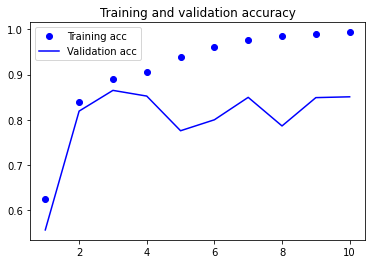

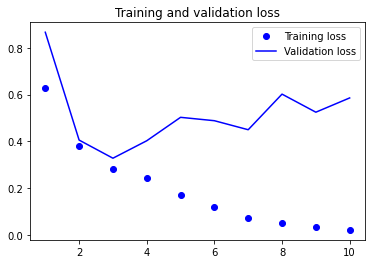

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

지금 이 순환 네트워크는 3.4의 신경망 모델보다 성능이 높지는 않음. 왜냐하면 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문.(얻은 정보가 적음) 그리고 다른 이유는 SimpleRNN이 텍스트와 같이 긴 시퀀스를 처리하는 데에는 적합하지 않기 때문.

<br>

## 케라스를 사용한 LSTM 예제

이번에는 LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련.

이 네트워크는 SimpleRNN 모델과 비슷. LSTM 층은 출력 차원만 지정하고 다른 매개변수들은 케라스의 기본값으로 남겨둠.

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 9s 27ms/step - loss: 0.5419 - acc: 0.7503 - val_loss: 0.4229 - val_acc: 0.8444
Epoch 2/10
157/157 [==============================] - 4s 23ms/step - loss: 0.3160 - acc: 0.8806 - val_loss: 0.3553 - val_acc: 0.8478
Epoch 3/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2402 - acc: 0.9100 - val_loss: 0.2900 - val_acc: 0.8890
Epoch 4/10
157/157 [==============================] - 3s 21ms/step - loss: 0.2034 - acc: 0.9248 - val_loss: 0.3203 - val_acc: 0.8702
Epoch 5/10
157/157 [==============================] - 3s 21ms/step - loss: 0.1801 - acc: 0.9348 - val_loss: 0.3726 - val_acc: 0.8554
Epoch 6/10
157/157 [==============================] - 3s 21ms/step - loss: 0.1638 - acc: 0.9409 - val_loss: 0.4304 - val_acc: 0.8502
Epoch 7/10
157/157 [==============================] - 3s 21ms/step - loss: 0.1483 - acc: 0.9470 - val_loss: 0.3814 - val_acc: 0.8782
Epoch 8/10
157/157 [==============================] - 3s 21ms/step - 

*84~88% 정도의 정확도*

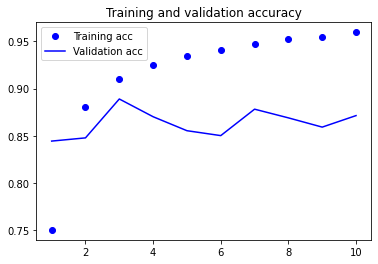

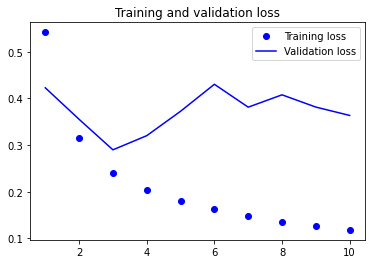

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 6.4 컨브넷 (Convnet)

## 1D 컨브넷 구현

케라스에서 1D 컨브넷은 Conv1D 층을 사용하여 구현. 이는 (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환. 합성곱 윈도우는 시간 축의 1D 윈도우, 즉 입력 텐서의 두 번째 축.

두 개의 층으로 된 1D 컨브넷을 만들어 IMDB 감성 분류에 적용.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링 층이나 Flatten 층으로 마침. 1D 컨브넷에 크기 7이나 9의 합성곱 윈도우를 사용 가능.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 7s 14ms/step - loss: 0.7008 - acc: 0.5397 - val_loss: 0.6826 - val_acc: 0.5776
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.6605 - acc: 0.6784 - val_loss: 0.6599 - val_acc: 0.6582
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.6113 - acc: 0.7699 - val_loss: 0.5973 - val_acc: 0.7180
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.5059 - acc: 0.8165 - val_loss: 0.4824 - val_acc: 0.7886
Epoch 5/10
157/157 [==============================] - 2s 10ms/step - loss: 0.3978 - acc: 0.8490 - val_loss: 0.4246 - val_acc: 0.8408
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.3326 - acc: 0.8784 - val_loss: 0.4041 - val_acc: 0.8540
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.2931 - acc: 0.8964 - val_loss: 0.4014 - val_acc: 0.8634
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.262

*검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됨. 단어 수준의 감성 분류 작업에서 순환 네트워크를 대신해 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줌.*

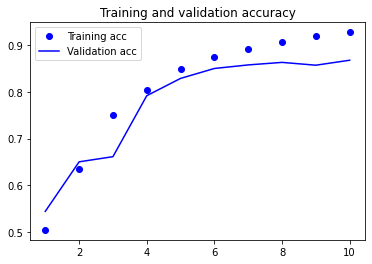

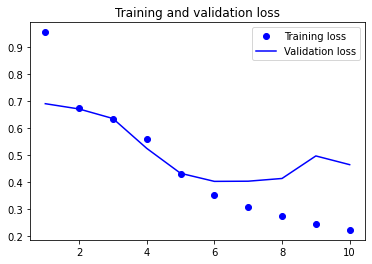

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## CNN과 RNN을 연결하여 긴 시퀀스를 처리

1D 컨브넷이 입력 패치를 독립적으로 처리하기에 RNN과는 달리 타임스텝의 순서에 민감하지 않음.

순서를 감지해야 좋은 예측을 할 수 있는 온도 예측 문제에 1D 컨브넷을 적용하여 확인.

In [ ]:
import os
import numpy as np

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
      
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 17s 31ms/step - loss: 0.4165 - val_loss: 0.4279
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3605 - val_loss: 0.4327
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3371 - val_loss: 0.4527
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3240 - val_loss: 0.4345
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3093 - val_loss: 0.4557
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3006 - val_loss: 0.4432
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2951 - val_loss: 0.4630
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2874 - val_loss: 0.4674
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2811 - val_loss: 0.4585
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2768 - val_los

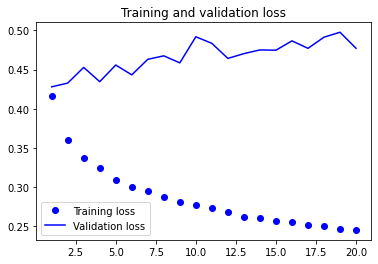

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*검증 MAE는 0.4대에 머물리 있음, 즉 작은 컨브넷을 사용했을때 그렇게 정확하지 않음. 이는 컨브넷이 입력 시계열의 패턴을 보고 시간 축의 위치를 고려하지 않기 때문.*

컨브넷의 속도와 경량을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 이용하는 것.

이를 온도 예측 문제에 적용. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래 전 데이터를 다루거나 시계열 데이터를 더 촘촘하게 바라볼 수 있음.

우선 제너레이터 함수를 다시 사용.

In [ ]:
step = 3
lookback = 1440 
delay = 144
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

모델에 두 개의 Conv1D 층 다음에 GRU 층을 놓음.

In [ ]:
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_4 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 133s 262ms/step - loss: 0.3258 - val_loss: 0.2977
Epoch 2/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2941 - val_loss: 0.2747
Epoch 3/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2804 - val_loss: 0.2761
Epoch 4/20
500/500 [==============================] - 128s 257ms/step - loss: 0.2683 - val_loss: 0.2768
Epoch 5/20
500/500 [==============================] - 127s 255ms/step - loss: 0.2612 - val_loss: 0.2795
Epoch 6/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2573 - val_loss: 0.2772
Epoch 7/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2497 - val_loss: 0.2849
Epoch 8/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2444 - val_loss: 0.2844
Epoch 9/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2394 - val_loss: 0.2989
Epoch 10/20
500/500 [==============================] - 129s 257ms/step - lo

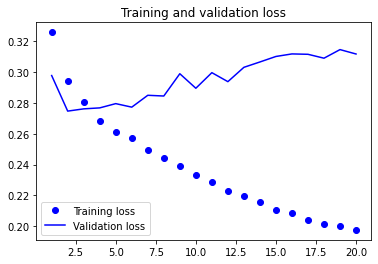

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*검증 손실로 비교 시, 규제가 있는 GRU 모델만큼 좋지는 않음. 하지만 훨씬 빠르기에 데이터를 두 배 더 많이 처리 가능.*

## 정리
- 2D 컨브넷은 2D 공간의 시각 패턴을 잘 처리하는 것과 같이, 1D 컨브넷은 시간에 따른 패턴(시계열 데이터)을 잘 처리. 즉, 특정 자연어 처리 같은 문제에 RNN을 대신할 수 있는 빠른 모델.
- 1D는 2D 컨브넷과 비슷하게 구성. Conv1D 층과 Max-Pooling1D 층을 쌓고 마지막에 전역 풀링 연산이나 Flatten 층을 둠.
- RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 높음. 1D 컨브넷은 비용이 적게 드므로 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하면 적은 비용으로 시퀀스 길이를 줄이고 RNN이 처리할 유용한 표현을 추출해줄 수 있음.